## **Algoritmo de filtraje no lineal basado en Operador de Koopman aplicado a epidemiología**

### **Capítulo 4: Algoritmo de filtraje no lineal en tiempo discreto**

**Autor: Diego Olguín.**

**Supervisores: Héctor Ramírez y Axel Osses.**

In [1240]:
chapter = "chapter4/"
img_path = "img/content/"+chapter

In [1241]:
# Librerías generales
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

sns.set_theme()

from sklearn.gaussian_process.kernels import Matern

# Plotly
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

# Librerías propias
import os

# Dependencias de KKKF
from KKKF.DynamicalSystems import DynamicalSystem
from KKKF.kEDMD import KoopmanOperator
import KKKF.applyKKKF as kkkf

In [1242]:
# Configuración de parámetros para Matplotlib
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 16})
plt.rcParams.update({'axes.titlesize': 16})
plt.rcParams.update({'legend.fontsize': 16})
plt.rcParams.update({'xtick.labelsize': 16})
plt.rcParams.update({'ytick.labelsize': 16})
plt.rcParams.update({'figure.figsize': (10, 6)})
plt.rcParams.update({'figure.titlesize': 20})

In [1243]:
# Ajustar directorio para las imagénes
root = "/Users/diegoolguin/Koopman_nonlinear_filter"
if not os.getcwd()==root:
    os.chdir(root)

### **Comparación con el filtro de Kalman**

In [1244]:
# Función que implementa el filtro de Kalman
def KalmanFilter(y, A, C, Q, R, x0, P0):
    """
    Implementación del filtro de Kalman para un sistema lineal.
    
    Args:
    y: np.array
        Observaciones del sistema.
    A: np.array
        Matriz de transición de estado.
    C: np.array
        Matriz de observación.
    Q: np.array
        Covarianza del ruido del sistema.
    R: np.array 
        Covarianza del ruido de las observaciones.
    x0: np.array    
        Estado inicial.
    P0: np.array
        Covarianza inicial.

    Returns:
    x: np.array
        Estados estimados.
    P: np.array
        Covarianza de los estados estimados.
    """

    # Número de observaciones
    iters = y.shape[1]
    
    # Inicialización de los vectores de estado y covarianza
    x = np.zeros((A.shape[0], iters))
    P = np.zeros((A.shape[0], A.shape[0], iters))
    
    # Inicialización de los estados y covarianza iniciales
    x[:, 0] = x0
    P[:, :, 0] = P0
    
    # Iteración del filtro
    for i in range(1, iters):
        # Predicción
        x[:, i] = A @ x[:, i-1]
        P[:, :, i] = A @ P[:, :, i-1] @ A.T + Q
        
        # Actualización
        K = P[:, :, i] @ C.T @ np.linalg.inv(C @ P[:, :, i] @ C.T + R)
        x[:, i] = x[:, i] + K @ (y[:, i] - C @ x[:, i])
        P[:, :, i] = P[:, :, i] - K @ C @ P[:, :, i]
    
    return x, P

In [1245]:
# Función para comparar los resultados del filtro de Kalman y el filtro no lineal
def compare_linear_filters(x0, x0_prior, A, C, Q, R, N, iters):
    """
    Función que compara los resultados del filtro de Kalman y el filtro no lineal.
    
    Args:
    x0: np.array
        Condición inicial verdadera.
    x0_prior: rv_continuous
        Distribución para el estado inicial
    A: np.array
        Matriz de transición de estado.
    C: np.array
        Matriz de observación.
    Q: np.array
        Covarianza del ruido del sistema.
    R: np.array
        Covarianza del ruido de las observaciones.
    N: int
        Dimensión de aproximación de Koopman
    iters: int
        Número de iteraciones.

    Returns:
    x: np.array
        Estados verdaderos del sistema.
    x_kalman: np.array
        Estados estimados por el filtro de Kalman.
    x_kkkf: np.array
        Estados estimados por el filtro no lineal.
    """
    # Funciones de dinámica y observación
    f = lambda x: A @ x
    g = lambda x: C @ x

    # Dimensiones
    nx, ny = A.shape[0], C.shape[0]

    # Distribuciones
    X_dist = stats.multivariate_normal(mean=np.zeros(nx), cov=1*np.eye(nx))
    dyn_dist = stats.multivariate_normal(mean=np.zeros(nx), cov=Q)
    obs_dist = stats.multivariate_normal(mean=np.zeros(ny), cov=R)

    # Sistema dinámico
    dyn = DynamicalSystem(nx, ny, f, g, X_dist, dyn_dist, obs_dist, discrete_time=True)

    # Operador de Koopman
    koopman = KoopmanOperator(kernel_function=Matern(length_scale=N**(2/3), nu=1.5), dynamical_system=dyn)

    # Trayectoria real y observaciones
    x = np.zeros((nx, iters))
    y = np.zeros((ny, iters))
    x[:, 0] = x0
    for i in range(1, iters):
        x[:, i] = A @ x[:, i-1] 
        y[:, i] = C @ x[:, i] + np.random.multivariate_normal(np.zeros(ny), R)

    # Inicialización de las covarianzas iniciales
    P0 = x0_prior.cov

    # Filtro de Kalman
    x_kalman, P_kalman = KalmanFilter(y, A, C, Q, R, x0_prior.mean, P0)

    # Filtro no lineal
    sol_kkkf = kkkf.apply_koopman_kalman_filter(koopman, y.T, x0_prior, N)
    x_kkkf, P_kkkf = sol_kkkf.x_plus.T, sol_kkkf.Px_plus

    return x, x_kalman, x_kkkf

In [1246]:
# Condición inicial real
x0 = np.array([1, 1, 1])

# Condición inicial prior
x0_prior = stats.multivariate_normal(mean=np.array([0.8, 1.2, 0.9]), cov=0.01*np.eye(3))

# Función para crear matrices de transición
A_fun = lambda alpha: np.array(
    [
        [1.01, 0.01, 0.0],
        [0.01, 1.02, alpha],
        [0.0, 0.04, 1.02]
    ]
)

# Matriz de observación
C = np.array([
    [1, 0, 0],
    [0, 1, 0],
])

# Dimensiones
nx, ny = len(x0), C.shape[0]

# Covarianzas del ruido
Q = 0.01*np.eye(nx)
R = 0.01*np.eye(ny)

# Número de dimensiones de aproximación
N = 500

# Número de iteraciones
iters = 30

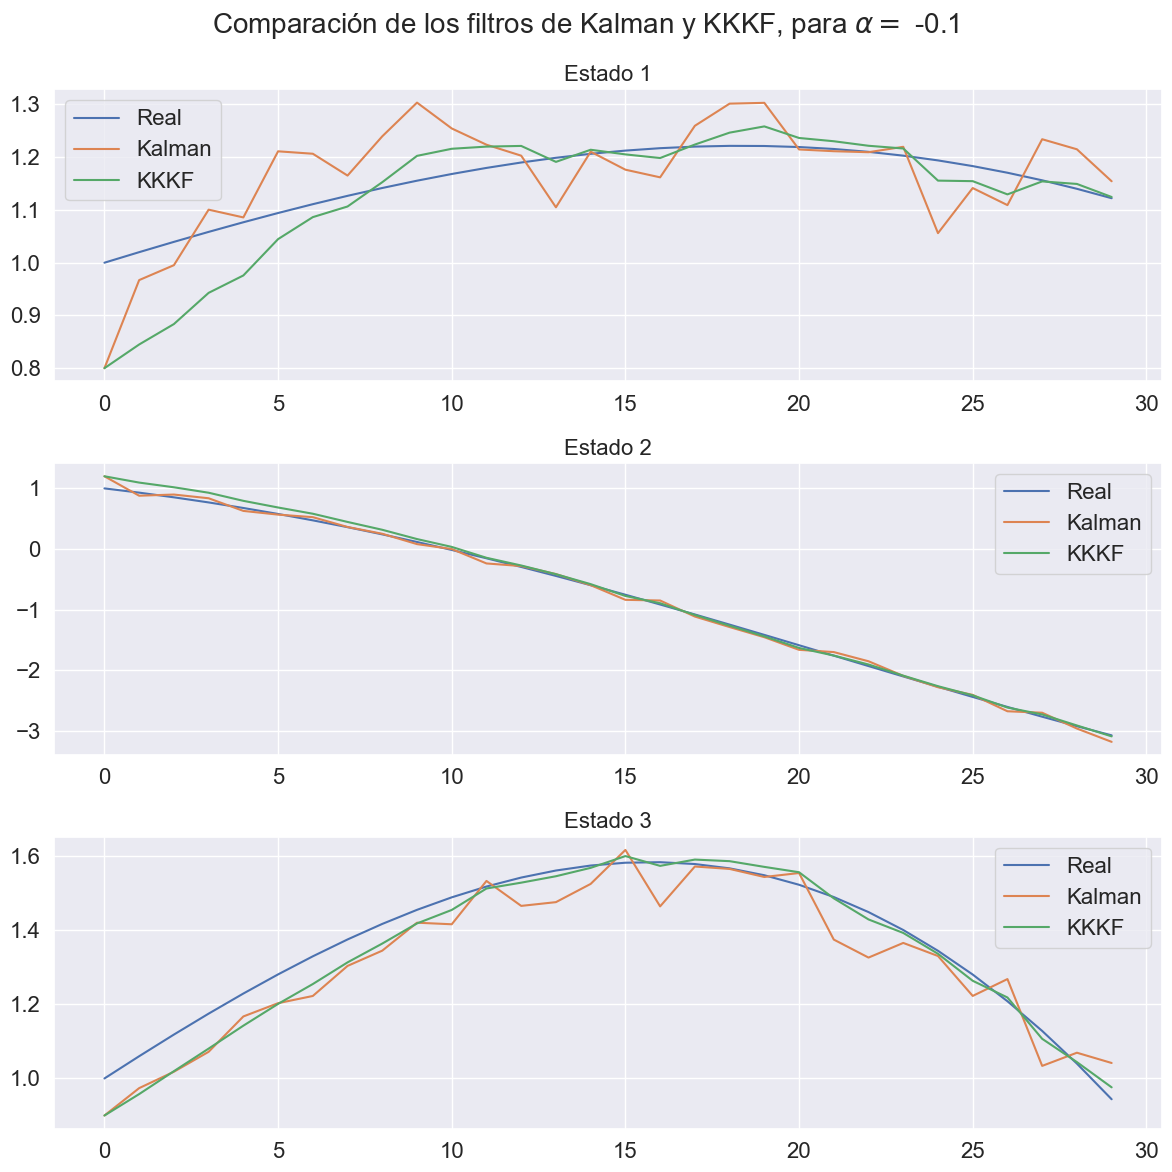

In [1247]:
# Comparación de los filtros
alpha = -0.1
A = A_fun(alpha)
x, x_kalman, x_kkkf = compare_linear_filters(x0, x0_prior, A, C, Q, R, N, iters)

fig, ax = plt.subplots(3, 1, figsize=(12, 12))

ax[0].plot(x[0, :], label='Real')
ax[0].plot(x_kalman[0, :], label='Kalman')
ax[0].plot(x_kkkf[0, :], label='KKKF')
ax[0].set_title('Estado 1')
ax[0].legend()

ax[1].plot(x[1, :], label='Real')
ax[1].plot(x_kalman[1, :], label='Kalman')
ax[1].plot(x_kkkf[1, :], label='KKKF')
ax[1].set_title('Estado 2')
ax[1].legend()

ax[2].plot(x[2, :], label='Real')
ax[2].plot(x_kalman[2, :], label='Kalman')
ax[2].plot(x_kkkf[2, :], label='KKKF')
ax[2].set_title('Estado 3')
ax[2].legend()

plt.suptitle(r'Comparación de los filtros de Kalman y KKKF, para $\alpha=$ {}'.format(alpha))
plt.tight_layout()
plt.show()

In [1248]:
# Guardar la figura
fig.savefig(img_path+"kalman_vs_kkkf_01.pdf")

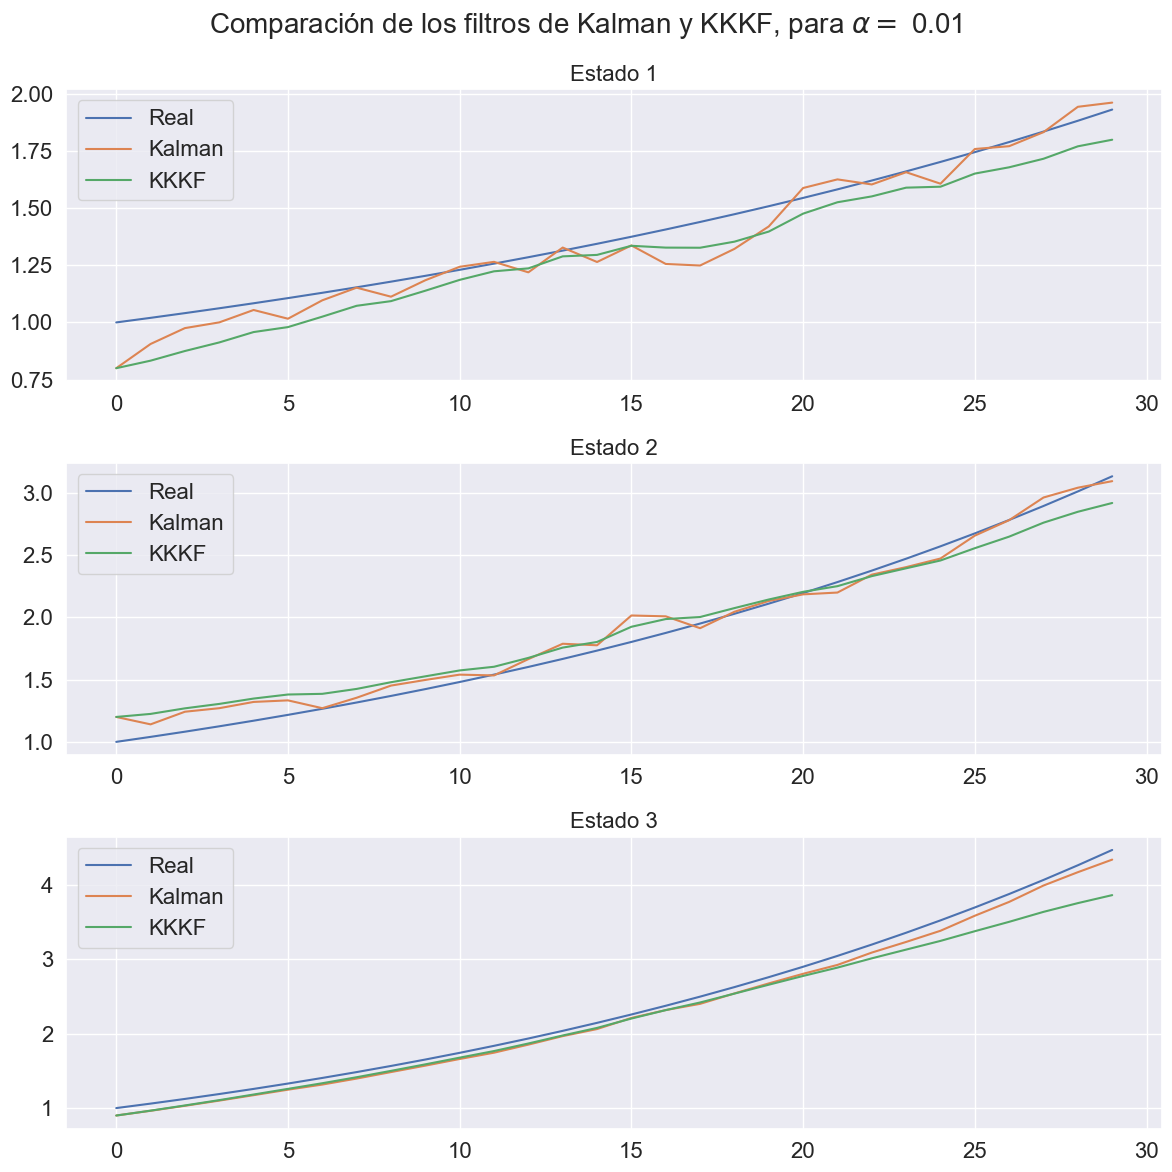

In [1249]:
# Comparación de los filtros
alpha = 0.01
A = A_fun(alpha)
x, x_kalman, x_kkkf = compare_linear_filters(x0, x0_prior, A, C, Q, R, N, iters)

fig, ax = plt.subplots(3, 1, figsize=(12, 12))

ax[0].plot(x[0, :], label='Real')
ax[0].plot(x_kalman[0, :], label='Kalman')
ax[0].plot(x_kkkf[0, :], label='KKKF')
ax[0].set_title('Estado 1')
ax[0].legend()

ax[1].plot(x[1, :], label='Real')
ax[1].plot(x_kalman[1, :], label='Kalman')
ax[1].plot(x_kkkf[1, :], label='KKKF')
ax[1].set_title('Estado 2')
ax[1].legend()

ax[2].plot(x[2, :], label='Real')
ax[2].plot(x_kalman[2, :], label='Kalman')
ax[2].plot(x_kkkf[2, :], label='KKKF')
ax[2].set_title('Estado 3')
ax[2].legend()

plt.suptitle(r'Comparación de los filtros de Kalman y KKKF, para $\alpha=$ {}'.format(alpha))
plt.tight_layout()
plt.show()

In [1250]:
# Guardar la figura
fig.savefig(img_path+"kalman_vs_kkkf_001.pdf")

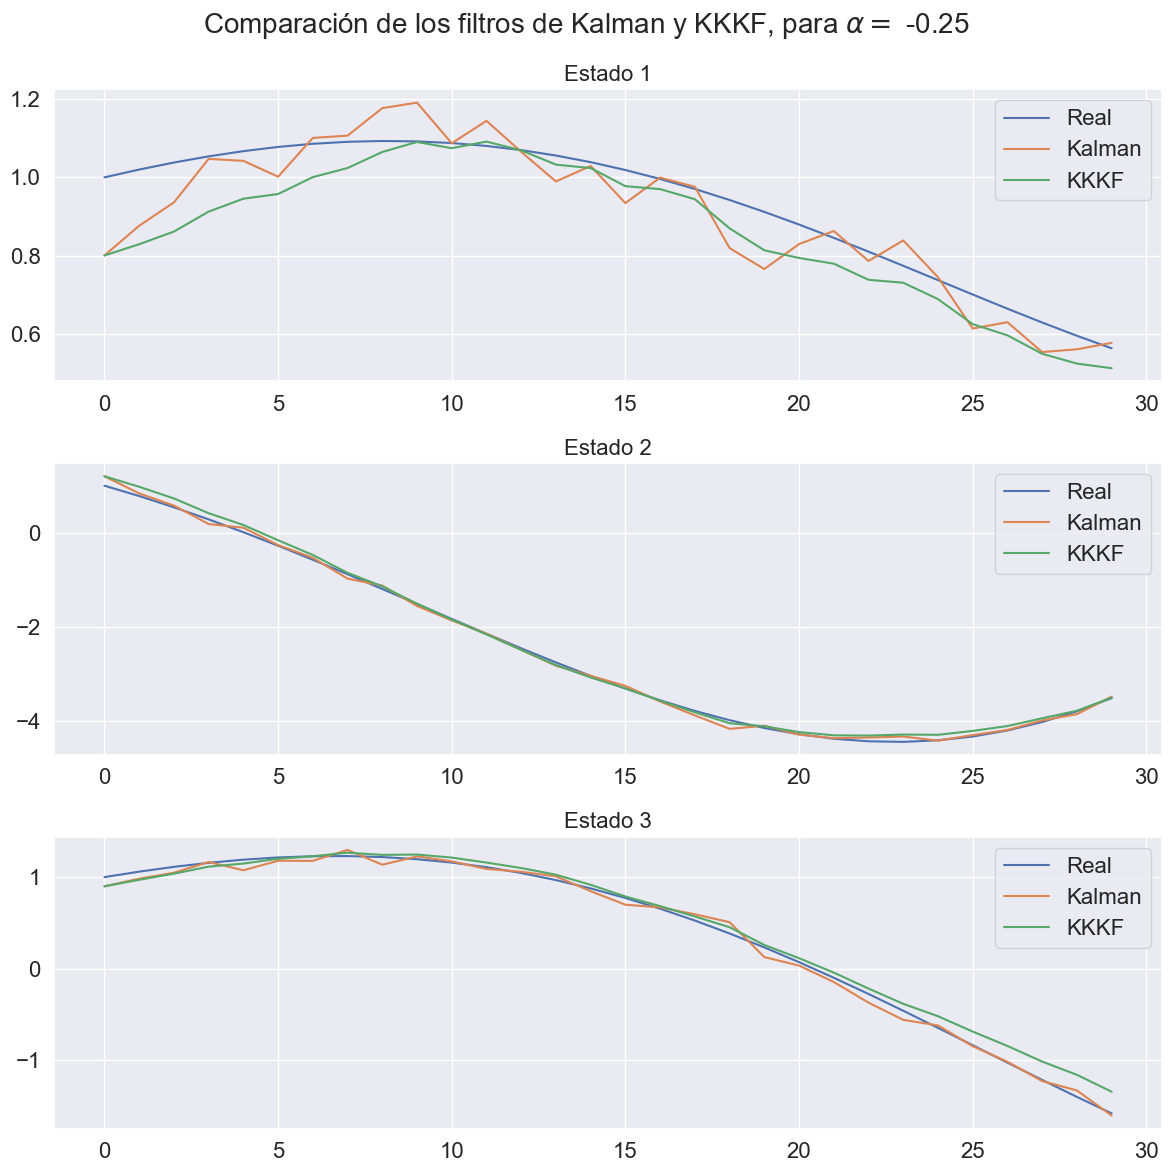

In [1251]:
# Comparación de los filtros
alpha = -0.25
A = A_fun(alpha)
x, x_kalman, x_kkkf = compare_linear_filters(x0, x0_prior, A, C, Q, R, N, iters)

fig, ax = plt.subplots(3, 1, figsize=(12, 12))

ax[0].plot(x[0, :], label='Real')
ax[0].plot(x_kalman[0, :], label='Kalman')
ax[0].plot(x_kkkf[0, :], label='KKKF')
ax[0].set_title('Estado 1')
ax[0].legend()

ax[1].plot(x[1, :], label='Real')
ax[1].plot(x_kalman[1, :], label='Kalman')
ax[1].plot(x_kkkf[1, :], label='KKKF')
ax[1].set_title('Estado 2')
ax[1].legend()

ax[2].plot(x[2, :], label='Real')
ax[2].plot(x_kalman[2, :], label='Kalman')
ax[2].plot(x_kkkf[2, :], label='KKKF')
ax[2].set_title('Estado 3')
ax[2].legend()

plt.suptitle(r'Comparación de los filtros de Kalman y KKKF, para $\alpha=$ {}'.format(alpha))
plt.tight_layout()
plt.show()

In [1252]:
# Guardar la figura
fig.savefig(img_path+"kalman_vs_kkkf_025.pdf")

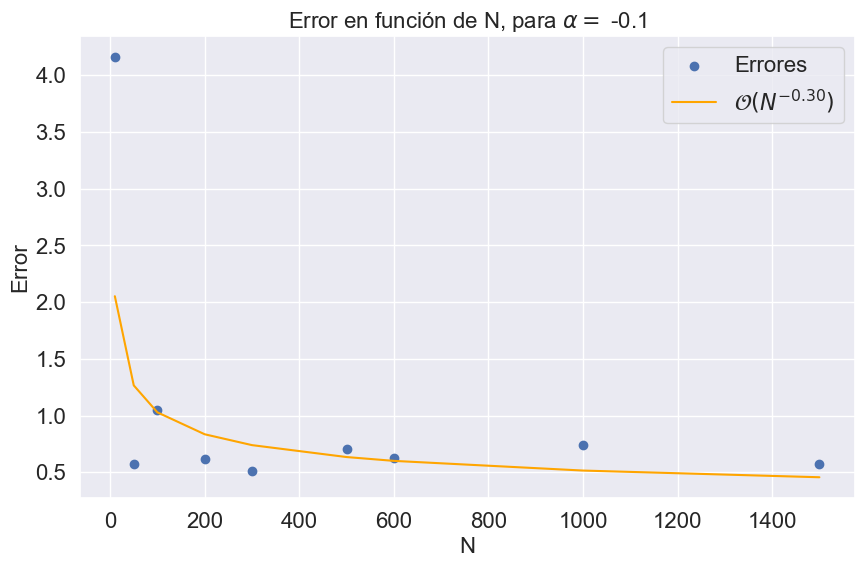

In [1253]:
# Calcular errores
alpha = -0.1
A = A_fun(alpha)

Ns = [10, 50, 100, 200, 300, 500, 600, 1000, 1500]

errors_kalman = []

for N in Ns:
    x, x_kalman, x_kkkf = compare_linear_filters(x0, x0_prior, A, C, Q, R, N, iters)
    errors_kalman.append(np.linalg.norm(x_kalman - x_kkkf))

# Ajustar una curva C*N**alpha
p = np.polyfit(np.log(Ns), np.log(errors_kalman), 1)

plt.scatter(Ns, errors_kalman, label='Errores')
plt.plot(Ns, np.exp(p[1])*Ns**p[0], label=r'$\mathcal{O}(N^{%.2f})$' % p[0], c='orange')
plt.xlabel('N')
plt.ylabel('Error')

plt.title(r'Error en función de N, para $\alpha=$ {}'.format(alpha))
plt.legend()

In [1254]:
plt.savefig(img_path+"error_vs_N_01.pdf")

<Figure size 1000x600 with 0 Axes>

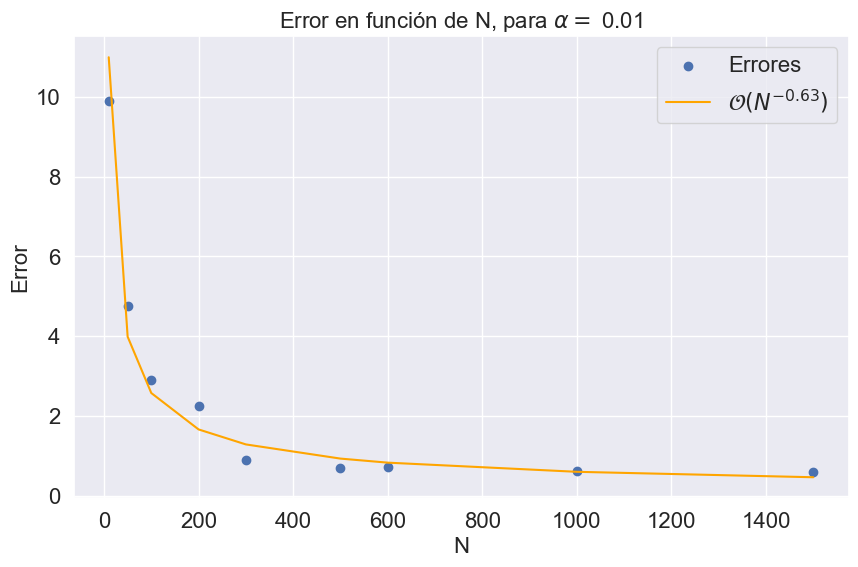

In [1255]:
# Calcular errores
alpha = 0.01
A = A_fun(alpha)

Ns = [10, 50, 100, 200, 300, 500, 600, 1000, 1500]

errors_kalman = []

for N in Ns:
    x, x_kalman, x_kkkf = compare_linear_filters(x0, x0_prior, A, C, Q, R, N, iters)
    errors_kalman.append(np.linalg.norm(x_kalman - x_kkkf))

# Ajustar una curva C*N**alpha
p = np.polyfit(np.log(Ns), np.log(errors_kalman), 1)

plt.scatter(Ns, errors_kalman, label='Errores')
plt.plot(Ns, np.exp(p[1])*Ns**p[0], label=r'$\mathcal{O}(N^{%.2f})$' % p[0], c='orange')
plt.xlabel('N')
plt.ylabel('Error')

plt.title(r'Error en función de N, para $\alpha=$ {}'.format(alpha))
plt.legend()

In [1256]:
plt.savefig(img_path+"error_vs_N_001.pdf")

<Figure size 1000x600 with 0 Axes>

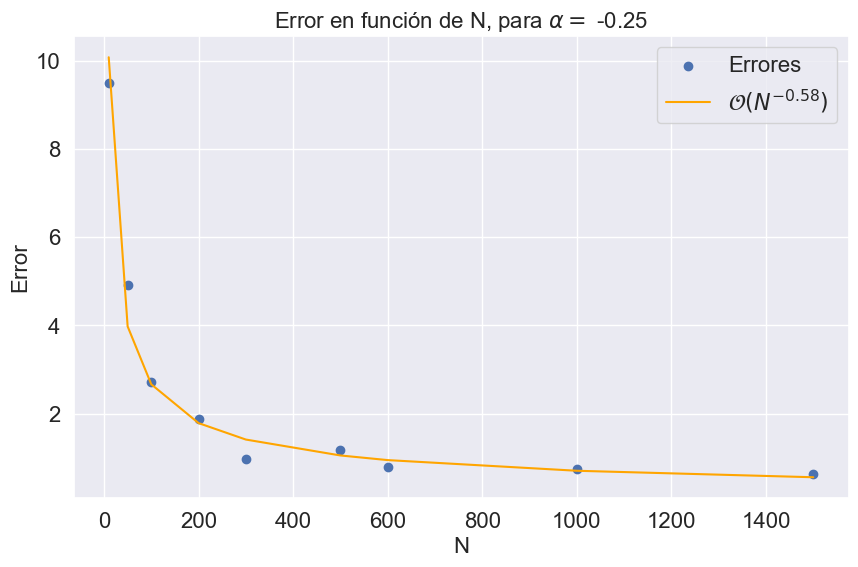

In [1257]:
# Calcular errores
alpha = -0.25
A = A_fun(alpha)

Ns = [10, 50, 100, 200, 300, 500, 600, 1000, 1500]

errors_kalman = []

for N in Ns:
    x, x_kalman, x_kkkf = compare_linear_filters(x0, x0_prior, A, C, Q, R, N, iters)
    errors_kalman.append(np.linalg.norm(x_kalman - x_kkkf))

# Ajustar una curva C*N**alpha
p = np.polyfit(np.log(Ns), np.log(errors_kalman), 1)

plt.scatter(Ns, errors_kalman, label='Errores')
plt.plot(Ns, np.exp(p[1])*Ns**p[0], label=r'$\mathcal{O}(N^{%.2f})$' % p[0], c='orange')
plt.xlabel('N')
plt.ylabel('Error')

plt.title(r'Error en función de N, para $\alpha=$ {}'.format(alpha))
plt.legend()

In [1258]:
plt.savefig(img_path+"error_vs_N_025.pdf")

<Figure size 1000x600 with 0 Axes>

### **Filtraje para el modelo SIR**

In [1259]:
# Función para calcular el jacobiano 
def jacobian(f, x, tol=1e-6):
    """
    Función que calcula el jacobiano de una función en un punto.

    Args:
    f: function
        Función a evaluar.
    x: np.array
        Punto de evaluación.
    tol: float
        Tolerancia para la aproximación de las derivadas.

    Returns:
    J: np.array
        Jacobiano de la función en el punto dado.
    """
    nx = x.shape[0]
    nf = f(x).shape[0]
    J = np.zeros((nf, nx))
    for i in range(nx):
        e = np.zeros(nx)
        e[i] = 1
        J[:, i] = (f(x + tol*e) - f(x - tol*e))/(2*tol)
    return J

In [1260]:
# Función que implementa el filtro de Kalman extendido
def ExtendedKalmanFilter(y, f, g, Q, R, x0, P0):
    """
    Implementación del filtro de Kalman extendido para un sistema no lineal.
    
    Args:
    y: np.array
        Observaciones del sistema.
    f: function
        Función de dinámica.
    g: function
        Función de observación.
    Q: np.array
        Covarianza del ruido del sistema.
    R: np.array 
        Covarianza del ruido de las observaciones.
    x0: np.array
        Estado inicial.
    P0: np.array    
        Covarianza inicial.

    Returns:
    x: np.array
        Estados estimados.
    P: np.array
        Covarianza de los estados estimados.
    """

    # Número de observaciones
    iters = y.shape[1]

    # Dimensiones
    nx, ny = len(x0), len(y[:,0])
    
    # Inicialización de los vectores de estado y covarianza
    x = np.zeros((iters, nx))
    P = np.zeros((iters, nx, nx))
    
    # Inicialización de los estados y covarianza iniciales
    x[0, :] = x0
    P[0, :, :] = P0
    
    # Iteración del filtro
    for i in range(1, iters):
        # Predicción
        x[i, :] = f(x[i-1, :])
        F = jacobian(f, x[i-1, :])
        P[i, :, :] = F @ P[i-1, :, :] @ F.T + Q
        
        # Actualización
        H = jacobian(g, x[i, :])
        K = P[i, :, :] @ H.T @ np.linalg.inv(H @ P[i, :, :] @ H.T + R)
        x[i, :] = x[i, :] + K @ (y[:, i] - g(x[i, :]))
        P[i, :, :] = P[i, :, :] - K @ H @ P[i, :, :]
    
    return x, P

In [1261]:
# Función para calcular los sigma points del Unscented Kalman Filter
def compute_sigma_points(x, P, alpha, beta, kappa):
    """
    Función que calcula los sigma points para el Unscented Kalman Filter.

    Args:
    x: np.array
        Estado.
    P: np.array
        Covarianza.
    alpha: float
        Parámetro de ajuste.
    beta: float
        Parámetro de ajuste.
    kappa: float
        Parámetro de ajuste.

    Returns:
    sigma_points: np.array
        Sigma points.
    Wm: np.array
        Pesos para la media.
    Wc: np.array
        Pesos para la covarianza.
    """

    nx = len(x)
    lambda_ = alpha**2 * (nx + kappa) - nx
    sigma_points = np.zeros((2 * nx + 1, nx))
    Wm = np.zeros(2 * nx + 1)
    Wc = np.zeros(2 * nx + 1)
    U = np.linalg.cholesky((lambda_ + nx) * P)
    sigma_points[0] = x
    Wm[0] = lambda_ / (nx + lambda_)
    Wc[0] = lambda_ / (nx + lambda_) + (1 - alpha**2 + beta)
    for i in range(nx):
        sigma_points[i + 1] = x + U[i]
        sigma_points[nx + i + 1] = x - U[i]
        Wm[i + 1] = Wm[nx + i + 1] = 1 / (2 * (nx + lambda_))
        Wc[i + 1] = Wc[nx + i + 1] = 1 / (2 * (nx + lambda_))
    return sigma_points, Wm, Wc

# Función que implementa Unscented Kalman Filter
def UnscentedKalmanFilter(y, f, g, Q, R, x0, P0, alpha=1e-3, beta=2, kappa=0):
    """
    Implementación del Unscented Kalman Filter para un sistema no lineal.
    
    Args:
    y: np.array
        Observaciones del sistema.
    f: function
        Función de dinámica.
    g: function
        Función de observación.
    Q: np.array 
        Covarianza del ruido del sistema.
    R: np.array
        Covarianza del ruido de las observaciones.
    x0: np.array
        Estado inicial.
    P0: np.array
        Covarianza inicial.

    Returns:
    x: np.array
        Estados estimados.
    P: np.array
        Covarianza de los estados estimados.
    """

    nx = len(x0)
    x_est = np.zeros((len(y), nx))
    P_est = np.zeros((len(y), nx, nx))
    x_est[0] = x0
    P_est[0] = P0
    x = x0
    P = P0

    for k in range(1, len(y)):
        # Generar los sigma points
        sigma_points, Wm, Wc = compute_sigma_points(x, P, alpha, beta, kappa)

        # Predicción
        sigma_points_pred = np.array([f(sp) for sp in sigma_points])
        x_pred = np.dot(Wm, sigma_points_pred)
        P_pred = Q + sum(Wc[i] * np.outer(sigma_points_pred[i] - x_pred, sigma_points_pred[i] - x_pred) for i in range(2 * nx + 1))

        # Acutualización
        sigma_points_meas = np.array([g(sp) for sp in sigma_points_pred])
        y_pred = np.dot(Wm, sigma_points_meas)
        P_zz = R + sum(Wc[i] * np.outer(sigma_points_meas[i] - y_pred, sigma_points_meas[i] - y_pred) for i in range(2 * nx + 1))
        P_xz = sum(Wc[i] * np.outer(sigma_points_pred[i] - x_pred, sigma_points_meas[i] - y_pred) for i in range(2 * nx + 1))
        K = np.dot(P_xz, np.linalg.inv(P_zz))
        x = x_pred + np.dot(K, y[k] - y_pred)
        P = P_pred - np.dot(K, np.dot(P_zz, K.T))

        x_est[k] = x
        P_est[k] = P

    return x_est, P_est

In [1262]:
# Función para comparar los resultados del filtro de Kalman y el filtro no lineal
def compare_nonlinear_filters(x0, x0_prior, f, g, X_dist, Q, R, N, iters):
    """
    Función que compara los resultados de EKF, UKF y KKKF.
    
    Args:
    x0: np.array
        Condición inicial verdadera.
    x0_prior: rv_continuous
        Distribución para el estado inicial
    f: function
        Función de dinámica.
    g: function
        Función de observación.
    X_dist: rv_continuous
        Distribución de los estados.
    Q: np.array
        Covarianza del ruido del sistema.
    R: np.array
        Covarianza del ruido de las observaciones.
    N: int
        Dimensión de aproximación de Koopman
    iters: int
        Número de iteraciones.

    Returns:
    x: np.array
        Estados verdaderos del sistema.
    x_ekf: np.array
        Estados estimados por EKF.
    x_ukf: np.array
        Estados estimados por UKF.
    x_kkkf: np.array
        Estados estimados por KKKF.
    """

    # Dimensiones
    nx, ny = f(x0).shape[0], g(x0).shape[0]

    # Distribuciones
    dyn_dist = stats.multivariate_normal(mean=np.zeros(nx), cov=Q)
    obs_dist = stats.multivariate_normal(mean=np.zeros(ny), cov=R)

    # Sistema dinámico
    dyn = DynamicalSystem(nx, ny, f, g, X_dist, dyn_dist, obs_dist, discrete_time=True)

    # Operador de Koopman
    koopman = KoopmanOperator(kernel_function=Matern(length_scale=1e3, nu=0.5), dynamical_system=dyn)

    # Trayectoria real y observaciones
    x = np.zeros((nx, iters))
    y = np.zeros((ny, iters))
    x[:, 0] = x0
    for i in range(1, iters):
        x[:, i] = f(x[:, i-1]) 
        y[:, i] = g(x[:, i]) + np.random.multivariate_normal(np.zeros(ny), R)

    # Inicialización de las covarianzas iniciales
    P0 = x0_prior.cov

    # EKF
    x_ekf, P_ekf = ExtendedKalmanFilter(y, f, g, Q, R, x0_prior.mean, P0)

    # UKF
    x_ukf, P_ukf = UnscentedKalmanFilter(y.T, f, g, Q, R, x0_prior.mean, P0)

    # KKF
    sol_kkkf = kkkf.apply_koopman_kalman_filter(koopman, y.T, x0_prior, N)
    x_kkkf, P_kkkf = sol_kkkf.x_plus.T, sol_kkkf.Px_plus

    return x, x_ekf, x_ukf, x_kkkf

In [1263]:
# Función de observación
g = lambda x: np.array([x[1]])

# Condición inicial real
x0 = np.array([0.9, 0.1, 0])

# Dimensiones
nx, ny = len(x0), g(x0).shape[0]

# Condición inicial prior
x0_prior = stats.multivariate_normal(mean=np.array([0.9, 0.05, 0.05]), cov=0.01*np.eye(nx))

# Distribuciones
X_dist = stats.dirichlet(alpha=np.array([1, 1, 1])) 

# Número de dimensiones de aproximación
N = 1000

# Número de iteraciones
iters = 20

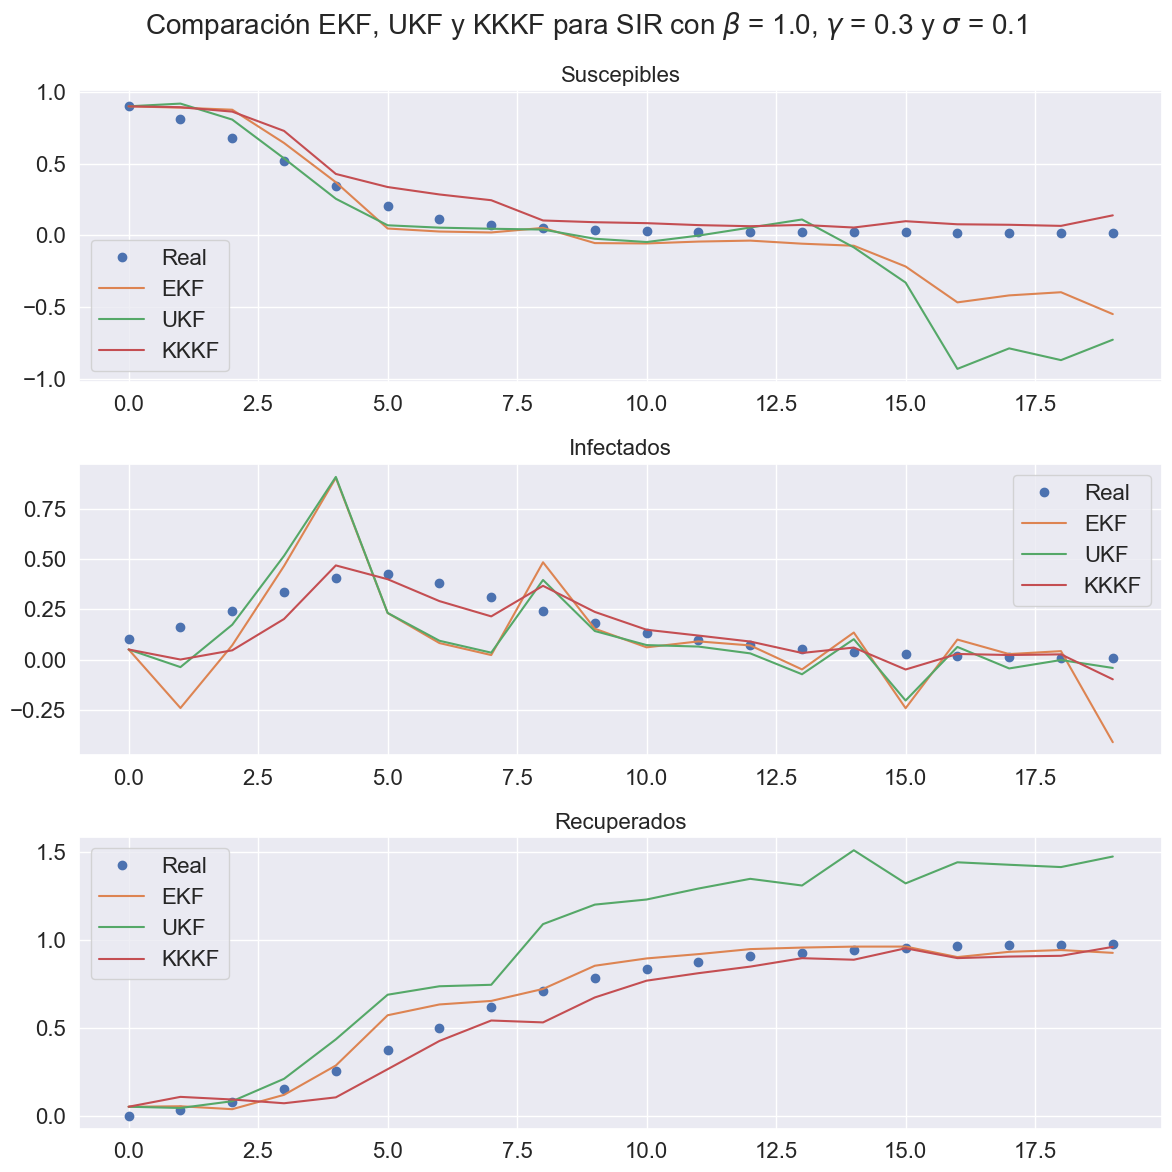

In [1264]:
# Testeo para modelo SIR

# Covarianzas del ruido
sigma = 0.1
Q = sigma*np.eye(nx)
R = sigma*np.eye(ny)

# Parámetros
beta = 1.
gamma = 0.3

# Funciones de dinámica y observación
f = lambda x: x + np.array([
    -beta*x[0]*x[1],
    beta*x[0]*x[1] - gamma*x[1],
    gamma*x[1]
])

# Soluciones
x, x_ekf, x_ukf, x_kkkf = compare_nonlinear_filters(x0, x0_prior, f, g, X_dist, Q, R, N, iters)

# Gráfico
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

ax[0].plot(x[0, :], 'o', label='Real')
ax[0].plot(x_ekf[:, 0], label='EKF')
ax[0].plot(x_ukf[:, 0], label='UKF')
ax[0].plot(x_kkkf.T[:, 0], label='KKKF')
ax[0].set_title('Suscepibles')
ax[0].legend()

ax[1].plot(x[1, :], 'o', label='Real')
ax[1].plot(x_ekf[:, 1], label='EKF')
ax[1].plot(x_ukf[:, 1], label='UKF')
ax[1].plot(x_kkkf.T[:, 1], label='KKKF')
ax[1].set_title('Infectados')
ax[1].legend()

ax[2].plot(x[2, :], 'o', label='Real')
ax[2].plot(x_ekf[:, 2], label='EKF')
ax[2].plot(x_ukf[:, 2], label='UKF')
ax[2].plot(x_kkkf.T[:, 2], label='KKKF')
ax[2].set_title('Recuperados')
ax[2].legend()

plt.suptitle(r'Comparación EKF, UKF y KKKF para SIR con $\beta$ = {}, $\gamma$ = {} y $\sigma$ = {}'.format(beta, gamma, sigma))
plt.tight_layout()

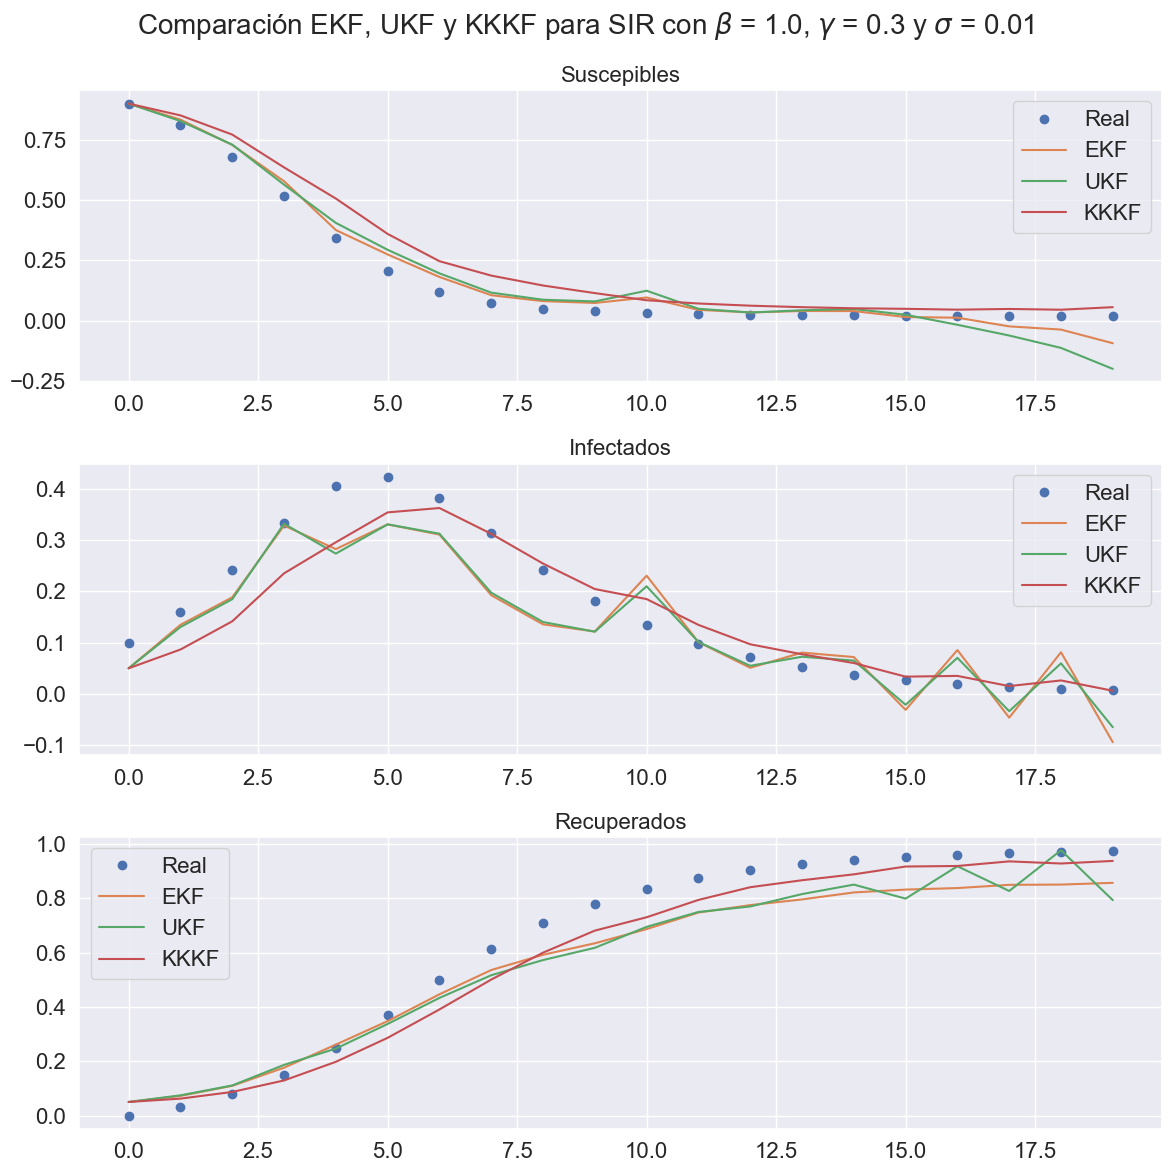

In [1265]:
# Testeo para modelo SIR

# Covarianzas del ruido
sigma = 0.01
Q = sigma*np.eye(nx)
R = sigma*np.eye(ny)

# Parámetros
beta = 1.
gamma = 0.3

# Funciones de dinámica y observación
f = lambda x: x + np.array([
    -beta*x[0]*x[1],
    beta*x[0]*x[1] - gamma*x[1],
    gamma*x[1]
])

# Soluciones
x, x_ekf, x_ukf, x_kkkf = compare_nonlinear_filters(x0, x0_prior, f, g, X_dist, Q, R, N, iters)

# Gráfico
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

ax[0].plot(x[0, :], 'o', label='Real')
ax[0].plot(x_ekf[:, 0], label='EKF')
ax[0].plot(x_ukf[:, 0], label='UKF')
ax[0].plot(x_kkkf.T[:, 0], label='KKKF')
ax[0].set_title('Suscepibles')
ax[0].legend()

ax[1].plot(x[1, :], 'o', label='Real')
ax[1].plot(x_ekf[:, 1], label='EKF')
ax[1].plot(x_ukf[:, 1], label='UKF')
ax[1].plot(x_kkkf.T[:, 1], label='KKKF')
ax[1].set_title('Infectados')
ax[1].legend()

ax[2].plot(x[2, :], 'o', label='Real')
ax[2].plot(x_ekf[:, 2], label='EKF')
ax[2].plot(x_ukf[:, 2], label='UKF')
ax[2].plot(x_kkkf.T[:, 2], label='KKKF')
ax[2].set_title('Recuperados')
ax[2].legend()

plt.suptitle(r'Comparación EKF, UKF y KKKF para SIR con $\beta$ = {}, $\gamma$ = {} y $\sigma$ = {}'.format(beta, gamma, sigma))
plt.tight_layout()

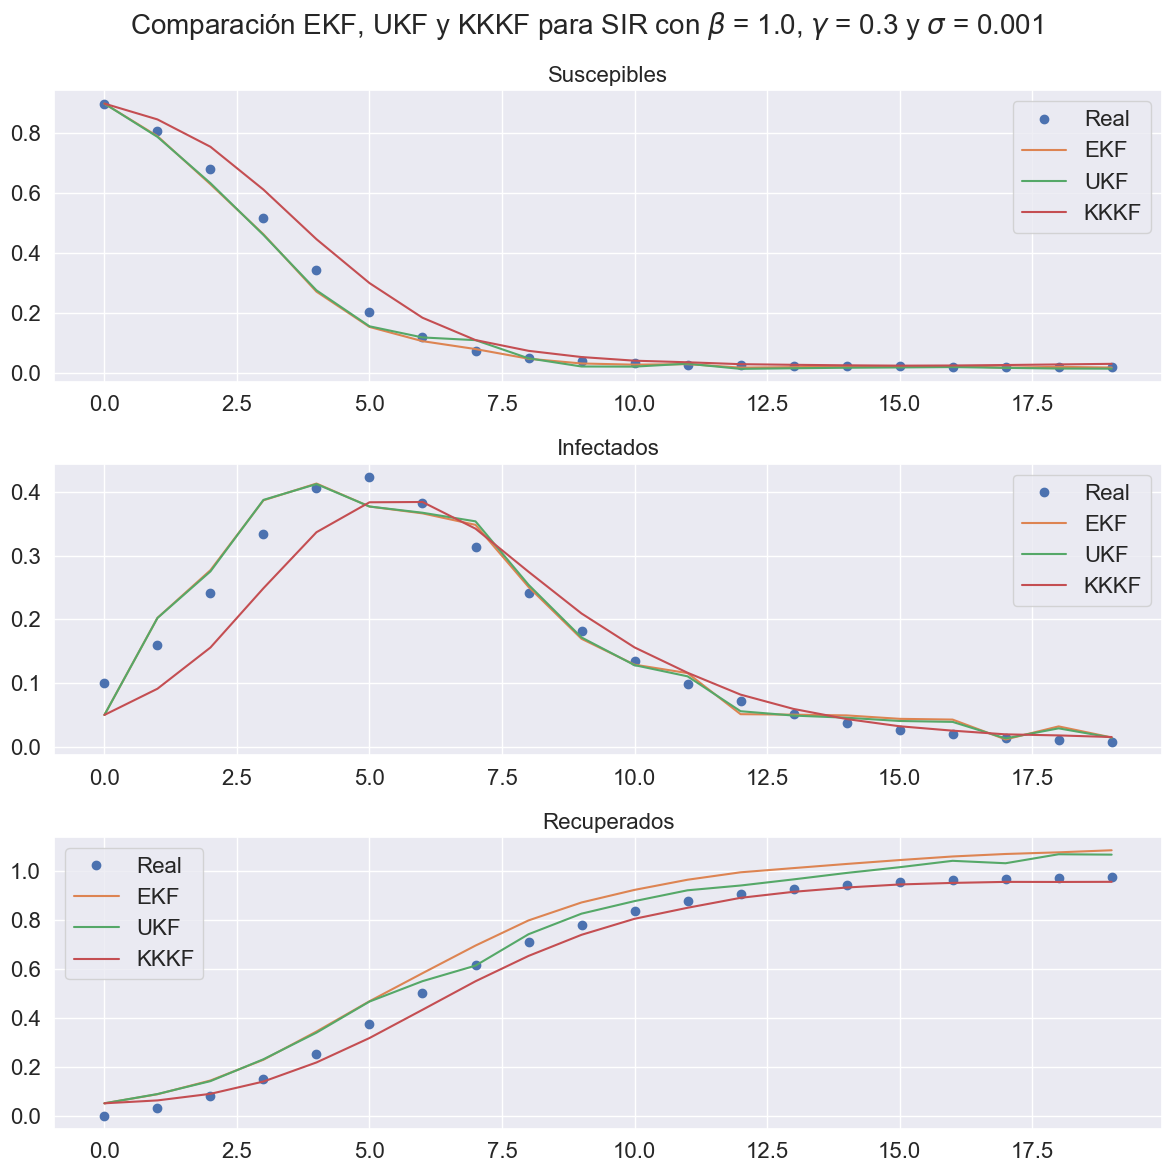

In [1266]:
# Testeo para modelo SIR

# Covarianzas del ruido
sigma = 0.001
Q = sigma*np.eye(nx)
R = sigma*np.eye(ny)

# Parámetros
beta = 1.
gamma = 0.3

# Funciones de dinámica y observación
f = lambda x: x + np.array([
    -beta*x[0]*x[1],
    beta*x[0]*x[1] - gamma*x[1],
    gamma*x[1]
])

# Soluciones
x, x_ekf, x_ukf, x_kkkf = compare_nonlinear_filters(x0, x0_prior, f, g, X_dist, Q, R, N, iters)

# Gráfico
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

ax[0].plot(x[0, :], 'o', label='Real')
ax[0].plot(x_ekf[:, 0], label='EKF')
ax[0].plot(x_ukf[:, 0], label='UKF')
ax[0].plot(x_kkkf.T[:, 0], label='KKKF')
ax[0].set_title('Suscepibles')
ax[0].legend()

ax[1].plot(x[1, :], 'o', label='Real')
ax[1].plot(x_ekf[:, 1], label='EKF')
ax[1].plot(x_ukf[:, 1], label='UKF')
ax[1].plot(x_kkkf.T[:, 1], label='KKKF')
ax[1].set_title('Infectados')
ax[1].legend()

ax[2].plot(x[2, :], 'o', label='Real')
ax[2].plot(x_ekf[:, 2], label='EKF')
ax[2].plot(x_ukf[:, 2], label='UKF')
ax[2].plot(x_kkkf.T[:, 2], label='KKKF')
ax[2].set_title('Recuperados')
ax[2].legend()

plt.suptitle(r'Comparación EKF, UKF y KKKF para SIR con $\beta$ = {}, $\gamma$ = {} y $\sigma$ = {}'.format(beta, gamma, sigma))
plt.tight_layout()

### **Algoritmo de estimación de parámetros**

In [1391]:
# Dinámica con los parámetros constantes
def f(x):
    S, I, R, beta, gamma = x 
    return x + np.array([
        -beta*S*I,
        beta*S*I - gamma*I,
        gamma*I,
        0*S, 
        0*I
    ])

# Observación
g = lambda x: np.array([x[0], x[1]])

# Parámetros
beta = 1.
gamma = 0.3

# Condición inicial
x0 = np.array([0.9, 0.1, 0, beta, gamma])

# Dimensiones
nx, ny = len(x0), g(x0).shape[0]

# Covarianzas 
sigma = 0.001
Q = np.diag([sigma, sigma, sigma, 0.1, 0.1])
R = sigma*np.eye(ny)

# Distibución Dirichlet en las primera 3 y uniforme en las otras 2
class DirichletUniform(stats.rv_continuous):
    def __init__(self, alpha, beta_lim, gamma_lim, momtype=1, a=None, b=None, xtol=1e-14, badvalue=None, name=None, longname=None, shapes=None, seed=None):
        super().__init__(momtype, a, b, xtol, badvalue, name, longname, shapes, seed)
        self.alpha = alpha
        self.beta_lim = beta_lim
        self.gamma_lim = gamma_lim
    
    def rvs(self, size=1):
        x = stats.dirichlet(self.alpha).rvs(size=size)
        y1 = stats.uniform(self.beta_lim[0], self.beta_lim[1]).rvs(size=size)
        y2 = stats.uniform(self.gamma_lim[0], self.gamma_lim[1]).rvs(size=size)

        return np.vstack([x.T, y1, y2]).T
    
X_dist = DirichletUniform(np.array([1, 1, 1]), [0.5, 1.5], [0.1, 0.5])
dyn_dist = stats.multivariate_normal(mean=np.zeros(nx), cov=Q)
obs_dist = stats.multivariate_normal(mean=np.zeros(ny), cov=R)
dyn = DynamicalSystem(nx, ny, f, g, X_dist, dyn_dist, obs_dist, discrete_time=True)

# Número de dimensiones de aproximación
N = 500

# Número de iteraciones
iters = 20

# Datos sintéticos
x, y = np.zeros((nx, iters)), np.zeros((ny, iters))
x[:, 0] = x0
for i in range(1, iters):
    x[:, i] = f(x[:, i-1]) 
    y[:, i] = g(x[:, i]) + np.random.multivariate_normal(np.zeros(ny), R)


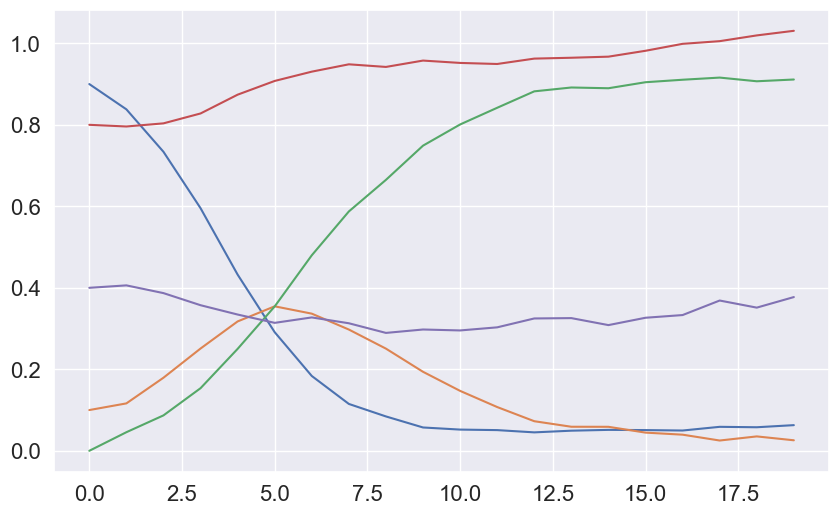

In [1394]:
x0_ = np.array([0.9, 0.1, 0, 0.8, 0.4])

x0_prior = stats.multivariate_normal(mean=x0_, cov=20*np.eye(5))

# Operador de Koopman
koopman = KoopmanOperator(kernel_function=Matern(length_scale=1e3, nu=0.5), dynamical_system=dyn)

# KKKF
sol_kkkf = kkkf.apply_koopman_kalman_filter(koopman, y.T, x0_prior, N)

plt.plot(sol_kkkf.x_plus)

In [ ]:
from scipy.optimize import minimize

# Función a minimizar
def loss(x):
    x0 = x[:5] 
    ls = x[-1]
    x0_prior = stats.multivariate_normal(mean=x0, cov=0.01*np.eye(5))

    # Operador de Koopman
    koopman = KoopmanOperator(kernel_function=Matern(length_scale=ls, nu=0.5), dynamical_system=dyn)

    # KKKF
    sol_kkkf = kkkf.apply_koopman_kalman_filter(koopman, y.T, x0_prior, N)

    return np.linalg.norm(g(sol_kkkf.x_plus.T) - y)

# Optimización
x0_ = np.array([0.9, 0.1, 0, 0.8, 0.4, 1e3])

#res = minimize(loss, x0_, method='Nelder-Mead', options={'disp': True})

/var/folders/rf/jjf6nprx39345csg42dq8wbr0000gn/T/ipykernel_25107/3977368947.py:20: RuntimeWarning:

Maximum number of function evaluations has been exceeded.



In [1321]:
# Función para calcular el gradiente
def gradient(f, x, tol=1e-6):
    """
    Función que calcula el gradiente de una función en un punto.

    Args:
    f: function
        Función a evaluar.
    x: np.array
        Punto de evaluación.
    tol: float
        Tolerancia para la aproximación de las derivadas.

    Returns:
    grad: np.array
        Gradiente de la función en el punto dado.
    """
    nx = x.shape[0]
    grad = np.zeros(nx)
    for i in range(nx):
        e = np.zeros(nx)
        e[i] = 1
        grad[i] = (f(x + tol*e) - f(x - tol*e))/(2*tol)
    return grad

In [1360]:
# Implementación de Adam 
def Adam(loss, x0, lr=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-8, iters=1000):
    """
    Implementación del algoritmo Adam para optimización.
    
    Args:
    loss: function
        Función a minimizar.
    x0: np.array
        Punto inicial.
    lr: float
        Tasa de aprendizaje.
    beta1: float
        Parámetro de ajuste.
    beta2: float
        Parámetro de ajuste.
    epsilon: float
        Tolerancia.
    iters: int  
        Número de iteraciones.

    Returns:
    x: np.array
        Punto óptimo.
    """
    
    x = x0
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    for t in range(1, iters + 1):
        g = gradient(loss, x)
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * g**2
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)
        x = x - lr * m_hat / (np.sqrt(v_hat) + epsilon)

    return x

In [1379]:
#Adam(loss, x0_, iters=50)

array([ 9.06484202e-01,  7.62849232e-02, -1.55617289e-02,  7.93046351e-01,
        3.99566940e-01,  9.99985361e+02])